# Offline policy evaluation - A contextual bandit case study.

This case study is about a common RL-adjacent problem: you have logs generated by an existing policy, and you want to estimate the performance of a new policy without deploying it.

Many interactive systems can be viewed as repeated decision problems. At each decision point, the system observes some context (the current situation), selects an action (a decision), and then observes an outcome (a reward, cost, or other signal of quality). A policy is the decision rule that maps observed context to actions.

A common workflow is:

1. propose multiple candidate policies
2. estimate their performance offline using logged data
3. choose a small set of candidates for online testing or deployment

This case study focuses on step 2 and emphasizes what makes it nontrivial: the available data was collected by an existing behavior policy, not by the new policy we want to evaluate.


### Problem setting: contextual bandit

We model each 'impression' as a contextual bandit round: one decision followed by an immediate outcome.

At round $t=1,\dots,T$:
1. observe context $x_t \in \mathcal{X}$ (user/session features)
2. choose action $a_t \in \mathcal{A}$ (which item to show, typically for a fixed position)
3. observe reward $r_t \in [0,R_{\max}]$ (click indicator, so $R_{\max}=1$)

A policy is a mapping from contexts to distributions over actions:
$$
\pi:\mathcal{X}\to\Delta(\mathcal{A}),
$$
where $\Delta(\mathcal{A})$ denotes the simplex of probability distributions over actions. The quantity $\pi(a\mid x)$ is the probability of choosing action $a$ in context $x$.

Examples:
1. Uniform Random: $\pi(a\mid x)=\frac{1}{|\mathcal{A}|}$
2. Deterministic greedy: $\pi(a^*(x)\mid x)=1, \pi(a\mid x)=0\ \text{for } a\neq a^*(x)$

The environment is characterized by an unknown context distribution $p(x)$ and an unknown reward mechanism $p(r\mid x,a)$. 
The mean reward function is $q(x,a)=\mathbb{E}[r\mid x,a].$

### Estimation target: value of a new policy

We want the expected reward (CTR) the evaluation policy $\pi_e$ would achieve if deployed:

$$
V(\pi_e)=\mathbb{E}_{x\sim p(x)}\Big[\mathbb{E}_{a\sim\pi_e(\cdot\mid x)}\mathbb{E}_{r\sim p(\cdot\mid x,a)}[r]\Big]
=\mathbb{E}_{x\sim p(x)}\Big[\mathbb{E}_{a\sim\pi_e(\cdot\mid x)}[q(x,a)]\Big].
$$

The difficulty is that we only observe rewards for actions chosen by $\pi_b$, not for the actions $\pi_e$ would have chosen. Offline policy evaluation resolves this by combining propensity information and reward modeling.

### How we solve it: core offline evaluation techniques

Offline estimators fall into two conceptual families:

- reward modeling: predict $q(x,a)$ using supervised learning
- importance weighting: reweight observed rewards to correct for policy mismatch

#### Direct Method
Direct method (DM) fits a model $\hat q(x,a)$ and evaluates by prediction:
$$
\hat V^{DM}(\pi_e;D,\hat q)=\mathbb{E}_D[\hat q(x_t,\pi_e)],
\quad
\hat q(x,\pi_e)=\sum_{a\in\mathcal{A}}\pi_e(a\mid x)\hat q(x,a).
$$

#### Inverse probability weighting (IPW) 
IPM re-weights observed rewards by imporance weights:

Importance weight : 

$$w(x,a)=\frac{\pi_e(a\mid x)}{\pi_b(a\mid x)}$$

$$
\hat V^{IPW}(\pi_e;D)=\mathbb{E}_D[w(x_t,a_t)r_t]$$

#### Doubly robust (DR): 
Combines DM and IPW:
$$
\hat V^{DR}(\pi_e;D,\hat q)=
\mathbb{E}_D\Big[\hat q(x_t,\pi_e)+w(x_t,a_t)\big(r_t-\hat q(x_t,a_t)\big)\Big].
$$


### Other techinques:

Self-normalized variants stabilize estimators when weights are heavy-tailed:

- Self-normalized IPW (SNIPW):
    $$
    \hat V^{SNIPW}(\pi_e;D)=
    \frac{\mathbb{E}_D[w(x_t,a_t)r_t]}{\mathbb{E}_D[w(x_t,a_t)]}.
    $$

- Self-normalized DR (SNDR):

    $$
    \hat V^{SNDR}(\pi_e;D,\hat q)=
    \mathbb{E}_D[\hat q(x_t,\pi_e)]
    +
    \frac{\mathbb{E}_D[w(x_t,a_t)(r_t-\hat q(x_t,a_t))]}{\mathbb{E}_D[w(x_t,a_t)]}.
    $$

- Switch-DR controls variance by using DM when weights are too large:
    $$
    \hat V^{SwitchDR}(\pi_e;D,\hat q,\tau)=
    \mathbb{E}_D\Big[\hat q(x_t,\pi_e)+w(x_t,a_t)\big(r_t-\hat q(x_t,a_t)\big)\mathbb{I}\{w(x_t,a_t)\le\tau\}\Big],
    $$
    where $\tau\ge 0$ tunes the bias–variance tradeoff.

More advanced DR variants such as MRDR and DR with optimistic shrinkage modify how the reward model or weights are chosen to reduce mean-squared error, especially under limited overlap.

In [16]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

plt.rcParams["figure.figsize"] = (10, 4)

def set_global_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)

set_global_seed(7)

## Data and bandit formalization

Each row is one displayed item at one position for one impression.

- context $x$: the information available at decision time (position, user features, user-item affinity features)
- action $a$: which item was shown (`item_id`) at that position
- reward $r$: click indicator (`click`)
- behavior propensity $p=\pi_b(a\mid x)$: the probability the logging policy chose that action in that context (`propensity_score`)

We will use two datasets:
- $D^{(bts)}$: logged by a non-uniform bandit policy (Bernoulli Thompson Sampling)
- $D^{(rand)}$: logged by a uniform random policy

Why two datasets are useful:
- $D^{(bts)}$ is a realistic "production-style" logger: propensities vary and overlap can be limited
- $D^{(rand)}$ lets us compute an on-policy reference for the random policy, so we can validate OPE end-to-end

In this notebook we treat each position as a separate contextual bandit round. This is a standard reduction when the reward depends on the displayed item and its position, and the log provides propensities per position.

In [17]:
# Adjust this if your dataset lives elsewhere
BASE = Path("data/open_bandit_dataset/open_bandit_dataset")

campaign = "men"   # e.g., "men", "women", or "all"
policy_behavior = "bts"      # behavior logs we will use for OPE
policy_onpolicy  = "random"  # dataset that truly ran the evaluation policy (random)

path_b = BASE / policy_behavior / campaign / f"{campaign}.csv"
path_e = BASE / policy_onpolicy  / campaign / f"{campaign}.csv"

df_b = pd.read_csv(path_b)
df_e = pd.read_csv(path_e)

print("behavior logs:", path_b)
print("on-policy logs:", path_e)
print("df_b shape:", df_b.shape)
print("df_e shape:", df_e.shape)

# Column groups
id_cols = ["timestamp", "item_id", "position", "click", "propensity_score"]
user_cols = [c for c in df_b.columns if c.startswith("user_feature_")]
aff_cols  = [c for c in df_b.columns if c.startswith("user-item_affinity_")]

print("user feature cols:", len(user_cols))
print("affinity cols:", len(aff_cols))
assert set(id_cols).issubset(df_b.columns), "expected core columns missing in df_b"
assert set(id_cols).issubset(df_e.columns), "expected core columns missing in df_e"

behavior logs: data\open_bandit_dataset\open_bandit_dataset\bts\men\men.csv
on-policy logs: data\open_bandit_dataset\open_bandit_dataset\random\men\men.csv
df_b shape: (4077727, 44)
df_e shape: (452949, 44)
user feature cols: 4
affinity cols: 34


## Quick EDA

We start with a few sanity checks:
- CTR overall and by position
- how often each item is shown (action frequency)
- propensity distribution (important for OPE variance)

Interpretation tip:
- in a random logger, propensities are typically (nearly) constant because every item is selected with the same probability
- in a bandit logger (e.g., Thompson sampling), propensities vary and can get very small, which can lead to heavy-tailed importance weights

In [18]:
def plot_bar(values, title, xlabel="", ylabel="", topn=None):
    v = values.copy()
    if topn is not None:
        v = v.head(topn)
    ax = v.plot(kind="bar")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

def ctr_table(df: pd.DataFrame, name: str):
    ctr = df["click"].mean()
    ctr_pos = df.groupby("position")["click"].mean().sort_index()
    cnt_pos = df["position"].value_counts().sort_index()
    out = pd.DataFrame({"impressions": cnt_pos, "ctr": ctr_pos})
    print(f"{name}: overall CTR={ctr:.5f}  (n={len(df):,})")
    display(out)

ctr_table(df_b, "behavior (bts)")
ctr_table(df_e, "on-policy (random)")

behavior (bts): overall CTR=0.00674  (n=4,077,727)


,impressions,ctr
position,,
1,1358878,0.007245
2,1359483,0.007038
3,1359366,0.005945


on-policy (random): overall CTR=0.00512  (n=452,949)


,impressions,ctr
position,,
1,150936,0.005380
2,151008,0.005245
3,151005,0.004748


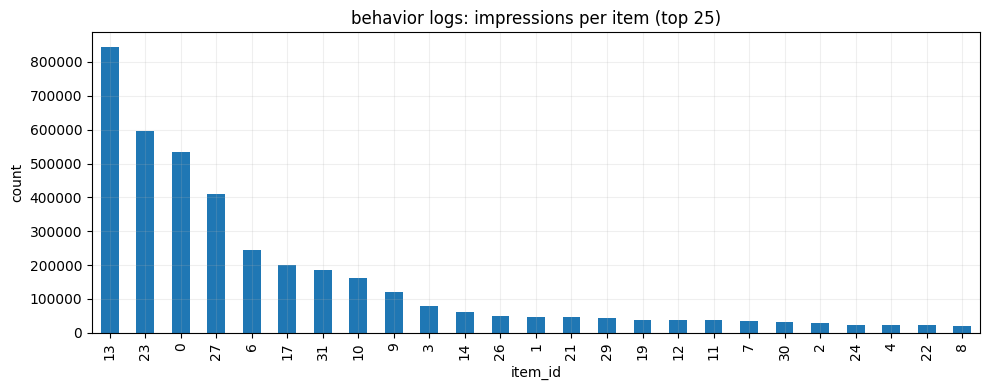

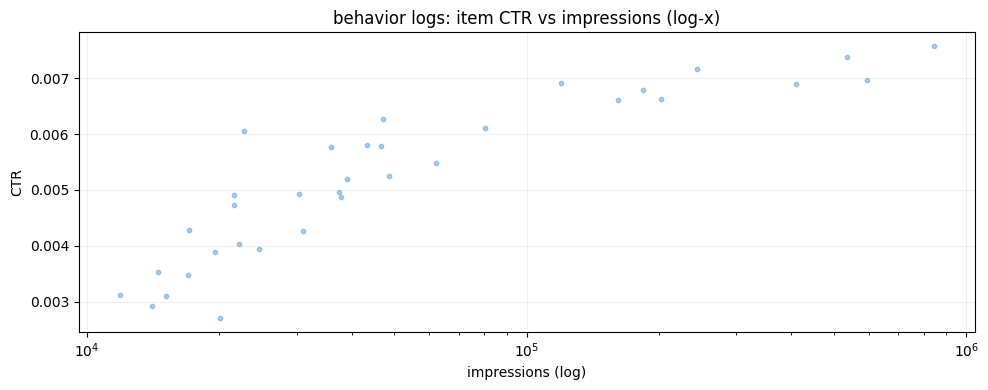

In [19]:
# action frequency and CTR-by-item (behavior logs)
item_cnt = df_b["item_id"].value_counts().sort_values(ascending=False)
plot_bar(item_cnt, "behavior logs: impressions per item (top 25)", xlabel="item_id", ylabel="count", topn=25)

item_stats = df_b.groupby("item_id")["click"].agg(["count","mean"]).rename(columns={"count":"impressions","mean":"ctr"})
plt.figure(figsize=(10,4))
plt.scatter(item_stats["impressions"], item_stats["ctr"], s=10, alpha=0.35)
plt.xscale("log")
plt.title("behavior logs: item CTR vs impressions (log-x)")
plt.xlabel("impressions (log)")
plt.ylabel("CTR")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

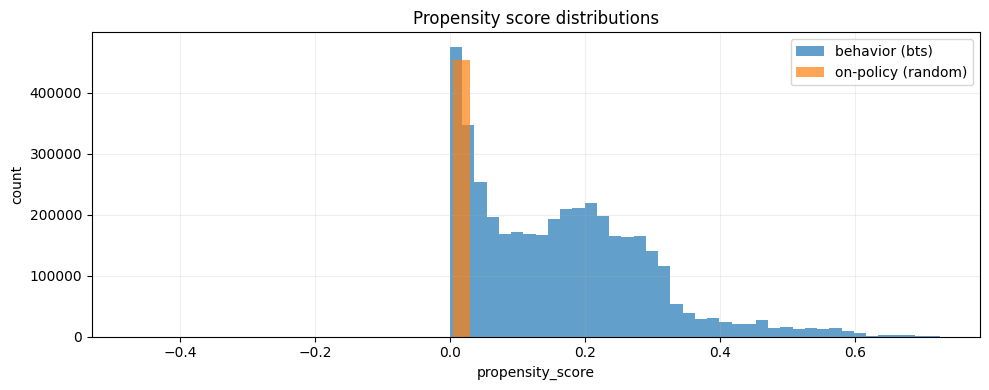

C:\Users\salmank\AppData\Local\Temp\ipykernel_14232\1391656487.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(p) for p in sorted(df_b["position"].unique())], showfliers=False)


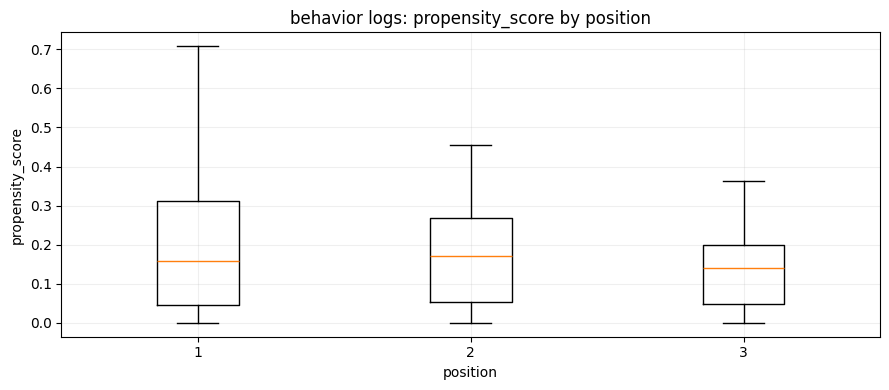

In [20]:
# propensity distributions (behavior vs random logger)
ps_b = df_b["propensity_score"].astype(float)
ps_e = df_e["propensity_score"].astype(float)

plt.figure(figsize=(10,4))
plt.hist(ps_b, bins=40, alpha=0.7, label="behavior (bts)")
plt.hist(ps_e, bins=40, alpha=0.7, label="on-policy (random)")
plt.title("Propensity score distributions")
plt.xlabel("propensity_score")
plt.ylabel("count")
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# by position for behavior logs
data = [df_b.loc[df_b["position"]==p, "propensity_score"].values for p in sorted(df_b["position"].unique())]
plt.figure(figsize=(9,4))
plt.boxplot(data, labels=[str(p) for p in sorted(df_b["position"].unique())], showfliers=False)
plt.title("behavior logs: propensity_score by position")
plt.xlabel("position")
plt.ylabel("propensity_score")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## OPE estimators we will use

We evaluate the uniform random policy
$$
\pi_{rand}(a\mid x)=\frac{1}{|\mathcal{A}|},
$$
so $\pi_{rand}(a\mid x)$ is known for any action $a$.

Given logged data $D=\{(x_t,a_t,r_t,p_t)\}_{t=1}^T$ with $p_t=\pi_b(a_t\mid x_t)$:

Importance weight:
$$
w_t=\frac{\pi_{rand}(a_t\mid x_t)}{\pi_b(a_t\mid x_t)}=\frac{1/|\mathcal{A}|}{p_t}.
$$

Direct method (DM):
1. fit a reward model $\hat q(x,a)\approx \mathbb{E}[r\mid x,a]$
2. evaluate by prediction
$$
\hat V^{DM}(\pi_{rand})=\frac{1}{T}\sum_{t=1}^T \hat q(x_t,\pi_{rand}),
\quad
\hat q(x,\pi_{rand})=\frac{1}{|\mathcal{A}|}\sum_{a\in\mathcal{A}}\hat q(x,a).
$$

Inverse probability weighting (IPW):
$$
\hat V^{IPW}(\pi_{rand})=\frac{1}{T}\sum_{t=1}^T w_t r_t.
$$

Self-normalized IPW (SNIPW):
$$
\hat V^{SNIPW}(\pi_{rand})=\frac{\sum_{t=1}^T w_t r_t}{\sum_{t=1}^T w_t}.
$$

Doubly robust (DR):
$$
\hat V^{DR}(\pi_{rand})=\frac{1}{T}\sum_{t=1}^T\Big[\hat q(x_t,\pi_{rand})+w_t\big(r_t-\hat q(x_t,a_t)\big)\Big].
$$

In this notebook:
- we use logistic regression as a simple reward model
- we use cross-fitting to compute $\hat q(x_t,a_t)$ out-of-fold, which reduces overfitting bias in the DR correction term

In [21]:
# ----------------------------
# Reward model + OPE implementation
# ----------------------------

def make_reward_model(cat_cols, num_cols) -> Pipeline:
    return Pipeline([
        ("prep", ColumnTransformer([
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", StandardScaler(), num_cols),
        ])),
        ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
    ])

def crossfit_qhat_logged(model: Pipeline, X: pd.DataFrame, y: pd.Series, n_splits: int = 3, seed: int = 0) -> np.ndarray:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    qhat = np.zeros(len(X), dtype=float)
    for tr_idx, te_idx in kf.split(X):
        model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        qhat[te_idx] = model.predict_proba(X.iloc[te_idx])[:, 1]
    return qhat

def qhat_under_uniform(model: Pipeline, X_base: pd.DataFrame, action_col: str, actions: np.ndarray) -> np.ndarray:
    # exact: average predictions over all actions
    qsum = np.zeros(len(X_base), dtype=float)
    for a in actions:
        X_cand = X_base.copy()
        X_cand[action_col] = a
        qsum += model.predict_proba(X_cand)[:, 1]
    return qsum / len(actions)

def ess(weights: np.ndarray) -> float:
    s1 = float(np.sum(weights))
    s2 = float(np.sum(weights * weights))
    return (s1 * s1 / s2) if s2 > 0 else 0.0

## Estimate the value of the random policy from bandit logs

We now use the behavior logs $D^{(bts)}$ as the input to OPE, and we estimate the value of the random policy.

Then we validate the result by comparing to the on-policy CTR computed directly from $D^{(rand)}$.

In [22]:
# Use a sample for speed 
MAX_N = 2_000_000

df_b_s = df_b.sample(min(MAX_N, len(df_b)), random_state=7).reset_index(drop=True)

reward_col = "click"
action_col = "item_id"
prop_col   = "propensity_score"

# action space
actions = np.sort(df_b_s[action_col].unique())
n_actions = len(actions)

# features
cat_cols = ["position"] + user_cols + [action_col]
num_cols = aff_cols

X = df_b_s[cat_cols + num_cols]
y = df_b_s[reward_col].astype(int)

r = df_b_s[reward_col].astype(float).to_numpy()
pb = df_b_s[prop_col].astype(float).to_numpy()

model = make_reward_model(cat_cols=cat_cols, num_cols=num_cols)

# cross-fitted qhat(x_t, a_t) for DR correction
qhat_logged = crossfit_qhat_logged(model, X, y, n_splits=3, seed=7)

# fit final model for counterfactual predictions
model.fit(X, y)

# qhat(x_t, pi_rand) for each context
qhat_pi_rand = qhat_under_uniform(model, X_base=X, action_col=action_col, actions=actions)

# evaluation policy probability for any action under uniform random
pi_e = 1.0 / n_actions

w = pi_e / np.clip(pb, 1e-12, None)

V_dm   = float(np.mean(qhat_pi_rand))
V_ipw  = float(np.mean(w * r))
V_snipw = float(np.sum(w * r) / np.sum(w))
V_dr   = float(np.mean(qhat_pi_rand + w * (r - qhat_logged)))

results = pd.DataFrame({
    "estimator": ["DM", "IPW", "SNIPW", "DR"],
    "estimate":  [V_dm, V_ipw, V_snipw, V_dr],
})

display(results)
print(f"behavior sample size: {len(df_b_s):,}")
print(f"n_actions: {n_actions}")
print(f"ESS(w): {ess(w):.1f}")

,estimator,estimate
0,DM,0.006121
1,IPW,0.005357
2,SNIPW,0.004953
3,DR,0.004866


behavior sample size: 2,000,000
n_actions: 34
ESS(w): 868.7


w summary: mean=1.082, median=0.191, p90=1.924, p99=12.358, p999=50.710, max=29411.765


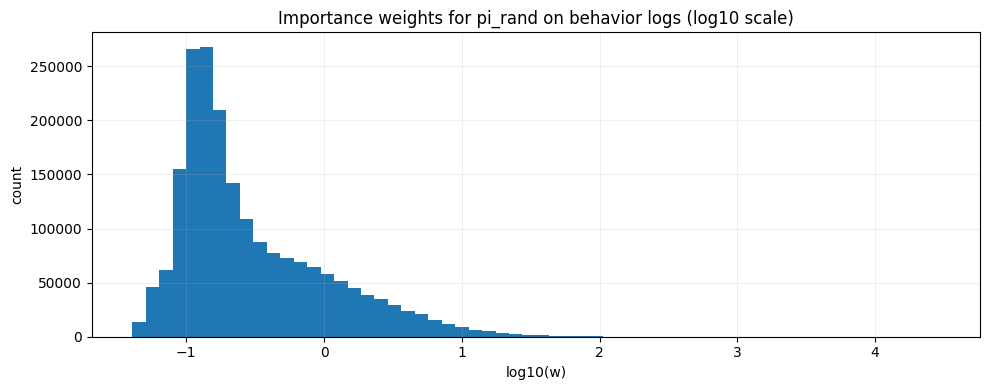

In [23]:
# Weight diagnostics
qs = np.quantile(w, [0.5, 0.9, 0.99, 0.999])
print(f"w summary: mean={w.mean():.3f}, median={qs[0]:.3f}, p90={qs[1]:.3f}, p99={qs[2]:.3f}, p999={qs[3]:.3f}, max={w.max():.3f}")

plt.figure(figsize=(10,4))
plt.hist(np.log10(w), bins=60)
plt.title("Importance weights for pi_rand on behavior logs (log10 scale)")
plt.xlabel("log10(w)")
plt.ylabel("count")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

In [24]:
# On-policy reference CTR for the random policy from df_e
# (sample to align sizes only for speed; the mean is unbiased either way)

df_e_s = df_e.sample(min(MAX_N, len(df_e)), random_state=7).reset_index(drop=True)
V_on_rand = float(df_e_s["click"].mean())

print(f"on-policy CTR of random policy (from random logs): {V_on_rand:.6f}")

# Compare DR to on-policy reference (relative error)
rel_err = abs(V_dr - V_on_rand) / max(V_on_rand, 1e-12)
print(f"relative error of DR estimate vs on-policy reference: {rel_err:.4%}")

on-policy CTR of random policy (from random logs): 0.005124
relative error of DR estimate vs on-policy reference: 5.0380%


In [26]:
# Bootstrap CI for OPE estimates (conditional on fitted qhat and weights)
# This captures sampling variability from the logged dataset.
# Full uncertainty would refit the reward model inside each bootstrap replicate.

B = 500
rng = np.random.default_rng(7)
n = len(df_b_s)

idx = rng.integers(0, n, size=(B, n))

def boot_mean(arr):
    return arr[idx].mean(axis=1)

boot_dm   = boot_mean(qhat_pi_rand)
boot_ipw  = boot_mean(w * r)
boot_dr   = boot_mean(qhat_pi_rand + w * (r - qhat_logged))

boot_snipw = np.sum((w*r)[idx], axis=1) / np.sum(w[idx], axis=1)

def ci(x, alpha=0.05):
    lo = np.quantile(x, alpha/2)
    hi = np.quantile(x, 1-alpha/2)
    return float(lo), float(hi)

summary = pd.DataFrame({
    "estimator": ["DM", "IPW", "SNIPW", "DR"],
    "estimate":  [V_dm, V_ipw, V_snipw, V_dr],
    "ci_low":    [ci(boot_dm)[0], ci(boot_ipw)[0], ci(boot_snipw)[0], ci(boot_dr)[0]],
    "ci_high":   [ci(boot_dm)[1], ci(boot_ipw)[1], ci(boot_snipw)[1], ci(boot_dr)[1]],
})
display(summary)

,estimator,estimate,ci_low,ci_high
0,DM,0.006121,0.006110,0.006130
1,IPW,0.005357,0.005024,0.005705
2,SNIPW,0.004953,0.004510,0.005440
3,DR,0.004866,0.004272,0.005463


## Takeaways

1. OPE needs propensities. The column `propensity_score` is what makes estimators like IPW and DR possible.
2. Weight tails determine stability. If behavior propensities are small, importance weights get large and variance increases.
3. DR is usually a strong default when you have both propensities and a reasonable reward model.
4. Always report diagnostics such as ESS and weight quantiles, and include uncertainty (e.g., bootstrap CIs).
5. When you have a second dataset where the evaluation policy actually ran, you can validate OPE end-to-end by comparing to the on-policy CTR.